In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import os

import re
from parser import parse_filename, natural_sort
import pandas as pd

from IPython import display
import time
import jax
from jax.config import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
from config import * 

import sys, os
sys.path.append("../src")
from checkpoint import find_ckpt_filename, load_data
from matplotlib.offsetbox import AnchoredText

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
ref_file = '../analysis/refs/pnas2016.csv'
ref_df = pd.read_csv(ref_file, delimiter=r"\s+")
ref_df

,T,rs,etot,p,k,vtot,f,s
0,1200,1.34,-0.51592,269.0,NaN,-1.3083,NaN,NaN
1,1200,1.35,-0.51813,257.7,NaN,NaN,NaN,NaN
2,1200,1.36,-0.51980,243.1,NaN,NaN,NaN,NaN
3,1200,1.37,-0.52200,232.5,NaN,NaN,NaN,NaN
4,1200,1.38,-0.52560,234.1,NaN,NaN,NaN,NaN
5,1200,1.39,-0.52700,224.0,NaN,NaN,NaN,NaN
6,1200,1.40,-0.53010,218.5,NaN,NaN,NaN,NaN
7,1200,1.41,-0.53175,206.9,NaN,NaN,NaN,NaN
8,1200,1.42,-0.53353,198.5,NaN,NaN,NaN,NaN
9,1200,1.43,-0.53540,189.5,NaN,NaN,NaN,NaN


In [12]:
def get_gr(x, y): 
    batchsize, n, dim = x.shape[0], x.shape[1], x.shape[2]
    

    L = (4/3*np.pi*n)**(1/3)
        
    i,j = np.triu_indices(n, k=1)
    rij = (np.reshape(x, (-1, n, 1, dim)) - np.reshape(y, (-1, 1, n, dim)))[:,i,j]
    rij = rij - L*np.rint(rij/L)
    dist = np.linalg.norm(rij, axis=-1) # (batchsize, n*(n-1)/2)
   
    hist, bin_edges = np.histogram(dist.reshape(-1,), range=[0, L/2], bins=300)
    dr = bin_edges[1] - bin_edges[0]
    hist = hist*2/(n * batchsize)

    rmesh = np.arange(hist.shape[0])*dr
    
    h_id = 4/3*np.pi*n/(L**3)* ((rmesh+dr)**3 - rmesh**3 )
    return rmesh*rs, hist/h_id

../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf/n_54_dim_3_rs_1.25_T_6000_fs_1_fd_3_fh1_32_fh2_16_wd_3_wh1_32_wh2_16_Nf_5_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_100_1000_mcwidth_0.02_0.04_lr_1_1_decay_0.01_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.1_ws_512_bs_4096_accsteps_1/data.txt


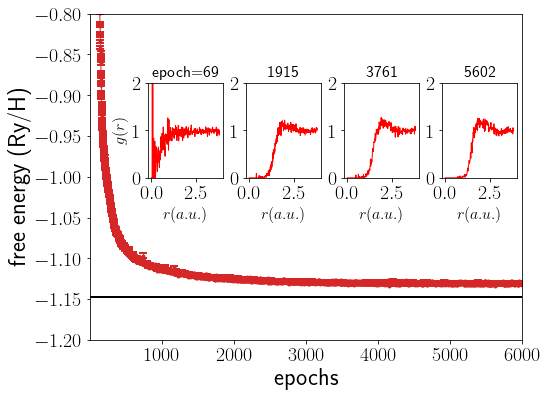

In [28]:
f = '../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf/n_54_dim_3_rs_1.25_T_6000_fs_1_fd_3_fh1_32_fh2_16_wd_3_wh1_32_wh2_16_Nf_5_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_100_1000_mcwidth_0.02_0.04_lr_1_1_decay_0.01_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.1_ws_512_bs_4096_accsteps_1/data.txt'


obs = 'f'
marker = 'o'
color = 'C3'

fig = plt.figure(figsize=(8, 6))
ax = plt.gca()
if True:
    
    n, dim, rs, T, s, fd, fh1, fh2, wd, wh1, wh2, b, a, lr, decay, eta, maxnorm, Nf, clip, K, w = parse_filename(f)
  
    print (f)
    df = pd.read_csv(f, delimiter=r"\s+")
    label = r'$n=%s,dim=%s,r_s=%s,T=%g,s=%s,fd=%s,fh_1=%s,fh_2=%s,wd=%s,wh_1=%s,wh_2=%s,Nf=%s,K=%s,b=%sx%s,lr=%s,decay=%s,eta=%s,nrm=%s,clip=%s, walkers=%s$'\
                %(n,dim,rs,T,s,fd,fh1,fh2,wd,wh1,wh2,Nf,K,b,a,lr,decay,eta,maxnorm,clip,w)
  
    Kp = 1.5*T/157887.66 # proton kinetic energy in Ry 
    
    if obs == 'f':
        y = df[obs].values + Kp +1.3452*T/157887.66 #Eq. (46) of https://code.itp.ac.cn/papers/hydrogen/-/blob/main/notes/notes.pdf
        yerr = df['f_err'].values    
    elif obs == 'vtot':
        y = df['vpp'].values + df['vep'].values + df['vee'].values
        yerr = np.sqrt(df['vpp_err'].values**2 + df['vep_err'].values**2 + df['vee_err'].values**2)       
    elif obs == 'etot':
        y = df['e'].values + df['vpp'].values
        yerr = np.sqrt(df['e_err'].values**2 + df['vpp_err'].values**2)
    elif obs in ['acc_s', 'acc_x']:
        y = df[obs].values
        yerr = np.zeros_like(y)
    else:
        y, yerr = df[obs].values, df[obs+'_err'].values
        
    ax.errorbar(df['epoch'].values, y, yerr=yerr,
                 marker=marker, color=color,markerfacecolor='none', 
                 markeredgewidth=2, ms=2, capsize=4, label=label)
    #plt.fill_between(df['epoch'].values, y-yerr, y+yerr , edgecolor='r',
    #                 facecolor='r',linewidth=2)
    
    #plt.xscale('log') 
    plt.xlim([1, 6000])
    plt.ylim([-1.2, -0.8])
    
    try:
        ref_value = ref_df.query('(T==%g) & (rs==%g)'%(T, rs))[obs].values[0]
        if obs in ['etot', 'k', 'vtot', 'f']: ref_value = 2*ref_value 
        plt.axhline(y=ref_value, color='k', lw=2, zorder=99)
                
    except KeyError or IndexError:
        print ('no ref data')
    
    path = os.path.dirname(f)
    ckpt_files = [os.path.join(path, f) for f in os.listdir(path) if ('pkl' in f)]
    ckpt_files = natural_sort(ckpt_files)
    ckpt_files = ckpt_files[:80]
    skips = len(ckpt_files)//3
    
    for offset, ckpt_file in enumerate(ckpt_files[::skips]):
        if ckpt_file is None: continue
        #print (ckpt_file)
        data = load_data(ckpt_file)
        epoch = int(re.search('epoch_([0-9]*).pkl', ckpt_file).group(1))
    
        s, x = data['s'], data['x']
        
        n, dim = x.shape[-2], x.shape[-1]
        s = s.reshape(-1, n, dim)
        x = x.reshape(-1, n, dim)
        
        walkersize, batchsize = s.shape[0], x.shape[0]
        if (walkersize != batchsize):
            s = jnp.repeat(s, batchsize//walkersize, 0)
        
        rmesh, gr = get_gr(s, s)
        left, bottom, width, height = [0.25+offset*0.17, 0.5, 0.13, 0.22]
        inset = fig.add_axes([left, bottom, width, height])
        inset.plot(rmesh, gr, 'r')
        inset.set_ylim([0, 2])
        if offset ==0:    
            plt.title(r'epoch=%g'%(epoch), fontsize=16)
        else:
            plt.title(r'%g'%(epoch), fontsize=16)
            
        if offset ==0: inset.set_ylabel('$g(r)$', fontsize=16)
        inset.set_xlabel('$r(a.u.)$', fontsize=16)
        
        #rmesh, gr = get_gr(s, x)
        #left, bottom, width, height = [0.25+offset*0.13, 0.4, 0.1, 0.15]
        #inset = fig.add_axes([left, bottom, width, height])
        #inset.plot(rmesh, gr, 'r')
        #inset.set_ylim([0, 8])
        #if offset ==0: inset.set_ylabel('$g_{ep}(r)$')
        
        
ax.set_ylabel('free energy (Ry/H)')
ax.set_xlabel('epochs')
plt.subplots_adjust(left=0.15)
plt.savefig('epoch.pdf')

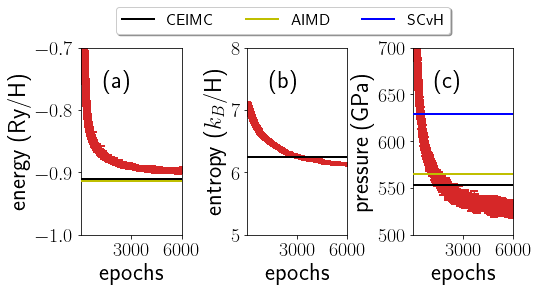

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(8, 4))

df = pd.read_csv(f, delimiter=r"\s+")
color = 'C3'

'''
#(a)
ax = ax1 
y = df['f'].values 
yerr = df['f_err'].values
        
ax.errorbar(df['epoch'].values, y, yerr=yerr,
            markerfacecolor='none', markeredgewidth=2, ms=2, capsize=8)
ax.set_ylabel('free energy')

ref_value = ref_df.query('(T==%g) & (rs==%g)'%(T, rs))['f'].values[0]
ax.axhline(y=2*ref_value, color='r', lw=2, zorder=99)
        
#ax.set_xscale('log')
#ax.xaxis.set_major_locator(plt.MaxNLocator(3))
#ax.set_xticks([100, 1000, 10000])
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

at = AnchoredText("(a)",prop=dict(size=24), frameon=False,loc=2)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at) 
''' 
   
Kp = 1.5*T/157887.66 # proton kinetic energy in Ry 

#(a)
ax = ax1
y = df['e'].values + df['vpp'].values +  Kp  
yerr = np.sqrt(df['e_err'].values**2 + df['vpp_err'].values**2)
        
ax.errorbar(df['epoch'].values, y, yerr=yerr, color=color,
            markerfacecolor='none', markeredgewidth=2, ms=2, capsize=4)
ax.set_ylabel('energy (Ry/H)')

ref_value = ref_df.query('(T==%g) & (rs==%g)'%(T, rs))['etot'].values[0] 
ref_value = 2*ref_value 
ax.axhline(y=ref_value, color='k', lw=2, zorder=99)
       
ref_value = -0.45675
ax.axhline(y=ref_value*2, color='y', lw=2, zorder=99)  
    
#ax.set_xscale('log')
#ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_xticks([3000, 6000])
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xlabel('epochs')
ax.set_xlim([1, 6000])
ax.set_ylim([-1.0, -0.7])

at = AnchoredText("(a)",prop=dict(size=24), frameon=False,loc=2)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)  


#(b)
ax = ax2
y = df['s'].values -1.3452 # Eq. (47) of https://code.itp.ac.cn/papers/hydrogen/-/blob/main/notes/notes.pdf -2*jax.scipy.special.gammaln(n+1)/n + 1.5*(1+np.log(1836*1.25**2/(4*np.pi)*6000/157887.6634))
yerr = df['s_err'].values
        
ax.errorbar(df['epoch'].values, y, yerr=yerr, color=color,
            markerfacecolor='none', markeredgewidth=2, ms=2, capsize=4)
ax.set_ylabel('entropy ($k_B$/H)')

ref_value = ref_df.query('(T==%g) & (rs==%g)'%(T, rs))['s'].values[0]
ax.axhline(y=ref_value, color='k', lw=2, zorder=99)
        
#ax.set_xscale('log')
#ax.xaxis.set_major_locator(plt.MaxNLocator(3))
#ax.set_xticks([100, 1000, 10000])
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xlabel('epochs')
ax.set_ylim([5, 8])


at = AnchoredText("(b)",prop=dict(size=24), frameon=False,loc=2)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)  

#(c)
ax = ax3 
L = (4/3*jnp.pi*n)**(1/3)
y = df['p'].values + (2*Kp)/(3*(L*rs)**3)*14710.513242194795*n
yerr = df[obs+'_err'].values       
    
ax.errorbar(df['epoch'].values, y, yerr=yerr, color=color,
            markerfacecolor='none', markeredgewidth=2, ms=2, capsize=4)
ax.set_ylabel('pressure (GPa)')

ref_value = ref_df.query('(T==%g) & (rs==%g)'%(T, rs))['p'].values[0]
l1 = ax.axhline(y=ref_value, color='k', lw=2, zorder=99)
        
ref_value = 565.1
l2 = ax.axhline(y=ref_value, color='y', lw=2, zorder=99)    
    
ref_value = 629.6 # figure 4 of https://journals.aps.org/pre/abstract/10.1103/PhysRevE.81.021202
l3 = ax.axhline(y=ref_value, color='b', lw=2, zorder=99)    
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
#          fancybox=True, shadow=True, ncol=5)

labels = ['CEIMC', 'AIMD', 'SCvH']
fig.legend( [l1, l2, l3], labels, loc = 'upper center', 
            bbox_to_anchor=(0.5, 1.02), 
            ncol=3 , fancybox=True, shadow=True)

#ax.set_xscale('log')
#ax.xaxis.set_major_locator(plt.MaxNLocator(3))
#ax.set_xticks([100, 1000, 10000])
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xlabel('epochs')
ax.set_ylim([500, 700])

at = AnchoredText("(c)",prop=dict(size=24), frameon=False,loc=2)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at) 

plt.subplots_adjust(wspace=0.65, left=0.15, bottom=0.2, top=0.85)
plt.savefig('obs.pdf')

../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf/n_54_dim_3_rs_1.2_T_5000_fs_1_fd_3_fh1_16_fh2_16_wd_3_wh1_16_wh2_16_Nf_5_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_50_500_mcwidth_0.02_0.04_lr_1_1_decay_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.1_ws_256_bs_2048_accsteps_2/epoch_000049.pkl
../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf/n_54_dim_3_rs_1.2_T_5000_fs_1_fd_3_fh1_16_fh2_16_wd_3_wh1_16_wh2_16_Nf_5_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_50_500_mcwidth_0.02_0.04_lr_1_1_decay_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.1_ws_256_bs_2048_accsteps_2/epoch_000967.pkl
../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf/n_54_dim_3_rs_1.2_T_5000_fs_1_fd_3_fh1_16_fh2_16_wd_3_wh1_16_wh2_16_Nf_5_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_50_500_mcwidth_0.02_0.04_lr_1_1_decay_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.1_ws_256_bs_2048_accsteps_2/epoch_001885.pkl
../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf/

(0.0, 2.0)

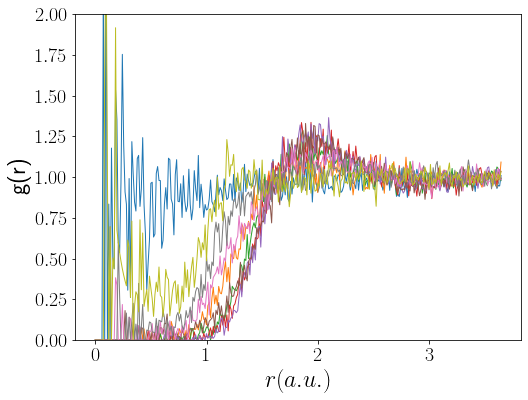

In [8]:
fig = plt.figure(figsize=(8, 6))

if True:
    
    #ckpt_file, _ = find_ckpt_filename(os.path.dirname(f))
    #ckpt_files = [ckpt_file]
    
    path = os.path.dirname(f)
    ckpt_files = [os.path.join(path, f) for f in os.listdir(path) if ('pkl' in f)]
    ckpt_files = natural_sort(ckpt_files)
    ckpt_files = ckpt_files[:len(ckpt_files)//2]
    #print (ckpt_files)
    skips = len(ckpt_files)//8
    
    for ckpt_file in ckpt_files[::skips]:
        if ckpt_file is None: continue
        print (ckpt_file)
        data = load_data(ckpt_file)
    
        s, x = data['s'], data['x']
        
        n, dim = x.shape[-2], x.shape[-1]
        s = s.reshape(-1, n, dim)
        x = x.reshape(-1, n, dim)
        
        walkersize, batchsize = s.shape[0], x.shape[0]
        if (walkersize != batchsize):
            s = jnp.repeat(s, batchsize//walkersize, 0)

        rmesh, gr = get_gr(s, s)
        plt.plot(rmesh, gr, label=r'$pp, rs=%g,n = %g$'%(rs, n))
  
        #rmesh, gr = get_gr(s, x)
        #plt.plot(rmesh, gr, label=r'$ep, rs=%g$'%rs) 
   
plt.xlabel('$r(a.u.)$')
plt.ylabel('g(r)')
plt.ylim([0, 2])